# Example Reading propagation files - bpfx

Import the necessary libs, after installing them in your environment. Please also ensure that lxml is installed by

conda install lxml

In [5]:
import matplotlib
import struct
import base64
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Now define the following class that load the fiberdesk propagation file (bpfx) that is actually an xml file, so pandas read_xml is used.

In [6]:
class fiberdesk_bpfx:
    def __init__(self, name):
        self.filename = name
        self.frames = 0
        self.bSecondFieldSaved = 0
        self.datapoints = 0
        self.time_intervall = 0.0
        self.freq_intervall = 0.0
        self.frequency_0 = 0.0
        self.distance = 0.0

        self.df = pd.read_xml(name)

        last_index = self.df.index.size-1 # minus header
        if "number_of_frames" in self.df.columns:
            self.frames = int(self.df.at[last_index,"number_of_frames"])
        #print(self.frames)
        entries = last_index / self.frames
        if "datapoints" in self.df.columns:
            self.datapoints = int(self.df.at[last_index,"datapoints"])
        #print(self.datapoints)

        # read axis from first entry (index 0), assume that it does no change along propagation
        if "freq_intervall" in self.df.columns:
            self.freq_intervall = self.df.at[0,"freq_intervall"]
        if "time_intervall" in self.df.columns:
            self.time_intervall  = self.df.at[0,"time_intervall"]
        if "FrequencyNull" in self.df.columns:
            self.frequency_0  = self.df.at[0,"FrequencyNull"]
        if "accumulated_distance" in self.df.columns:
            pos = self.df["accumulated_distance"].dropna().to_numpy()
            self.distance = np.max(pos)-np.min(pos)
            #print(self.distance)

    def __del__(self):
        return

    def GetSavedFields(self):
        fields = np.zeros( (self.frames,self.datapoints),dtype=complex)
        if "binary-complex-values" in self.df.columns:
            for frame in range(self.frames):
                str_data = self.df["binary-complex-values"].dropna().values.tolist()
                if frame<len(str_data):
                    fmt = "<%dd" % (self.datapoints*2)
                    numbers = np.asarray(struct.unpack(fmt, base64.b64decode(str_data[frame])))
                    fields[frame] = numbers[0::2]+1j*numbers[1::2]
        return fields

Now we are able to read all fields from a file. We also calculate the spectrum via fft.

In [7]:
filename = 'propagation.bpfx'

fd = fiberdesk_bpfx(filename)   #read file and info
data_time = fd.GetSavedFields() # get propagation field array

data_spec = np.copy(data_time)
for i in range(fd.frames):
    data_spec[i] = np.fft.ifftshift(np.fft.fft(data_time[i],norm='ortho')) # normalization to keep energy same as temporal domain

We plot the energy of the field and its sepctrum as an example how to work with the fields. It should be the same of course.

Text(0, 0.5, 'energy / J')

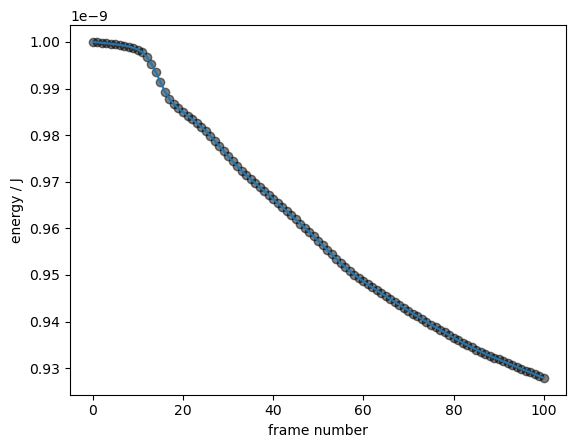

In [8]:
field = np.real(np.conj(data_time)*data_time)
energy = np.sum(field,axis=1)   # energy at each position
energy_s = np.sum(np.real(np.conj(data_spec)*data_spec),axis=1) # energy at each position, will be the same as energy

fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.plot(energy,'o',color='black',alpha=0.5)
ax0.plot(energy_s) # will be the same as 'energy'
ax0.set_xlabel('frame number')
ax0.set_ylabel('energy / J')

The following code takes some variables loaded with the field, like temporal intervall and data point to make axis and plot the propagation in a 2D plot.

min/max = -460.57589336589126 dB -102.74109895144767 dB
distance 0.1999999999999986


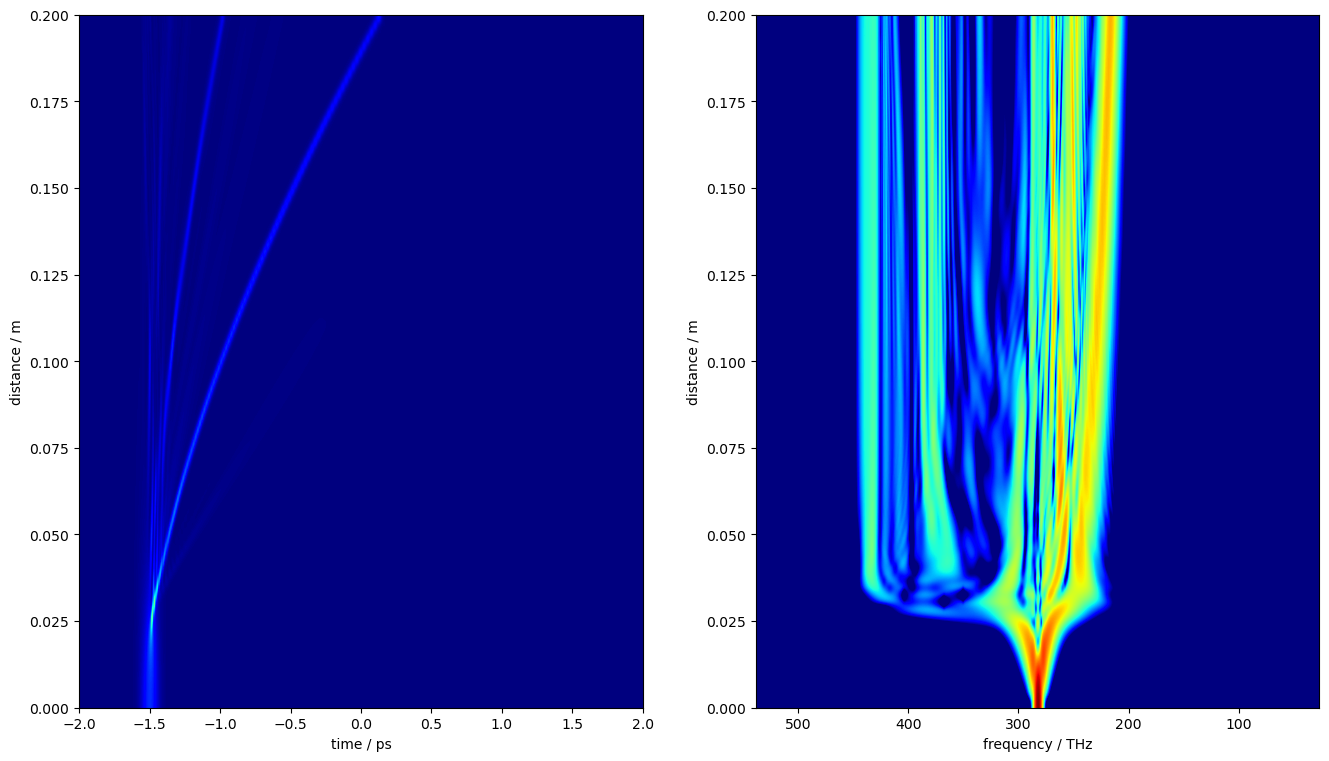

In [10]:
N = fd.datapoints
# temporal extend
t_min = -fd.time_intervall / 2.0 * 1e12  # ps
t_max = +fd.time_intervall / 2.0 * 1e12  # ps
# spectral extend in Hz
s_min = (fd.frequency_0 - fd.freq_intervall / 2.0) * 1e-12
s_max = (fd.frequency_0 + fd.freq_intervall / 2.0) * 1e-12

def secure_log10_intensity(data):
# turn array to log10 of its absolute values(squared) and make sure not to use zeros or below, fill those to min value
    res_int = np.real(np.conj(data)*data)
    res = np.zeros_like(res_int)
    p = np.where(res_int >0.0)
    p_avoid = np.where(res_int <=0.0)
    res_int_min=np.min(res_int[p])
    res[p] = 10.0*np.log10(res_int[p])
    res[p_avoid] = 10.0*np.log10(res_int_min)
    return res 
    
# calc absolute values from complex array in logarithmic scale
spec = secure_log10_intensity(data_spec)

spec_min=np.min(spec)
spec_max=np.max(spec)
print('min/max =',spec_min,'dB',spec_max,'dB')
field_min = np.min(field)
field_max = np.max(field)

# extend of range in logarithmic spectral plot
db_range = 30.0 # dB
# extend of range in linear time plot
lin_range = 1.0#0.2 # use only 20% of linear range, measured from min

fig2 = plt.figure(figsize=(16, 9), dpi=100)
ax2 = fig2.add_subplot(121)
bx2 = fig2.add_subplot(122)
print('distance',fd.distance)
dist_label = 'distance / m'
if (fd.distance == 0.0):
    fd.distance = data_time.shape[0]
    dist_label = 'roundtrip'
# draw the field
ax2.imshow(field,aspect='auto',interpolation='bicubic',cmap='jet',origin='lower',vmin=field_min,vmax=field_min+(field_max-field_min)*lin_range,extent=[t_min,t_max,0,fd.distance])

ax2.set_xlabel('time / ps')
ax2.set_ylabel(dist_label)

# draw the spectrum
bx2.imshow(spec,aspect='auto',interpolation='bicubic',cmap='jet',vmin=spec_max-db_range,vmax=spec_max,origin='lower',extent=[s_max,s_min,0,fd.distance])

bx2.set_xlabel('frequency / THz')
bx2.set_ylabel(dist_label)

plt.show()
